<a href="https://colab.research.google.com/github/nisar8400/Hate-Speech-Detection-using-Transformers-and-LLMs/blob/main/distilbert_bert_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Mar 31 23:50:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0  On |                  Off |
|  0%   46C    P8             16W /  450W |     338MiB /  24564MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 1080/1080 [02:56<00:00,  6.11it/s]


Training Loss: 0.5018
Validation Loss: 0.5445, Validation Accuracy: 0.8824
Epoch 2/5


100%|██████████| 1080/1080 [02:56<00:00,  6.13it/s]


Training Loss: 0.3082
Validation Loss: 0.4782, Validation Accuracy: 0.9027
Epoch 3/5


100%|██████████| 1080/1080 [02:56<00:00,  6.13it/s]


Training Loss: 0.2789
Validation Loss: 0.4779, Validation Accuracy: 0.9075
Epoch 4/5


100%|██████████| 1080/1080 [02:56<00:00,  6.13it/s]


Training Loss: 0.2505
Validation Loss: 0.5052, Validation Accuracy: 0.9035
Epoch 5/5


100%|██████████| 1080/1080 [02:56<00:00,  6.12it/s]


Training Loss: 0.2180
Validation Loss: 0.5030, Validation Accuracy: 0.9075

Final Evaluation Metrics:
Accuracy: 0.9075
              precision    recall  f1-score   support

    Not Hate       0.93      0.99      0.96       595
   Sarcastic       0.98      0.84      0.90       211
    Explicit       0.78      0.78      0.78       220
    Implicit       0.92      0.88      0.90       207

    accuracy                           0.91      1233
   macro avg       0.90      0.87      0.88      1233
weighted avg       0.91      0.91      0.91      1233



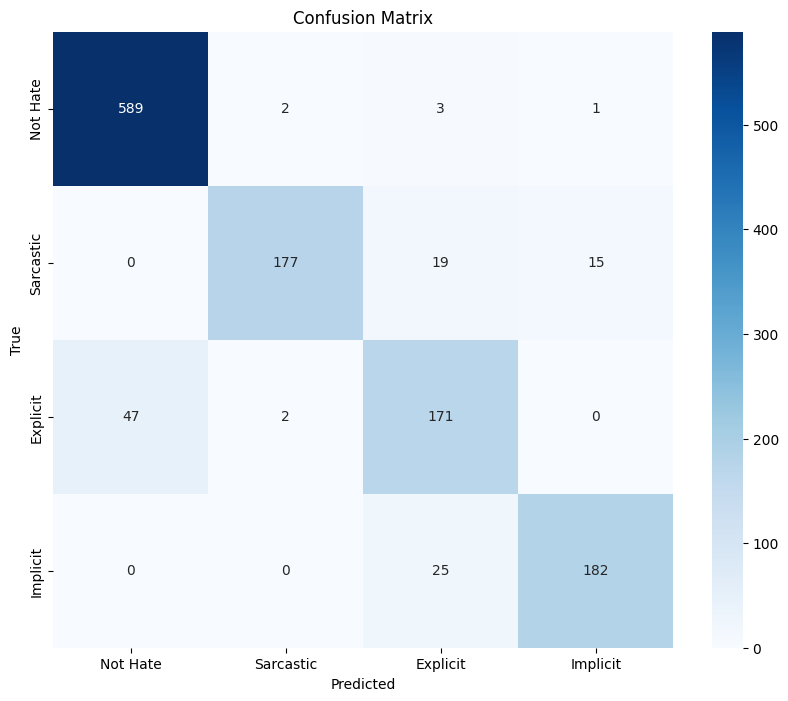

Metrics saved to distilbert-base-uncased_metrics.txt
Test Loss: 1.3976, Test Accuracy: 0.6956
Sample Predictions: [np.int64(3), np.int64(0), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3)]


In [12]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords

# ------------------------------ NLTK ------------------------------
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# ------------------------------ Robust loaders ------------------------------
def load_split(path):
    """
    Load a split CSV robustly:
    - auto-detect delimiter
    - if only one column present, split last token as label
    - handle merged header cases like 'sentence\tNormalized_Label'
    - normalize labels (strip, fix 'Hate' -> 'Not Hate')
    """
    df = pd.read_csv(path, sep=None, engine="python")
    df.columns = df.columns.str.strip()

    # Already good?
    if {"sentence", "Normalized_Label"}.issubset(df.columns):
        out = df[["sentence", "Normalized_Label"]].copy()
    else:
        # One-column case: sentence + trailing label in same field
        if df.shape[1] == 1:
            s = df.iloc[:, 0].astype(str).str.strip()
            # label is last non-space token
            labels = s.str.extract(r"(\S+)$")[0]
            sentence = s.str.replace(r"\s+\S+$", "", regex=True)
            out = pd.DataFrame({"sentence": sentence, "Normalized_Label": labels})
        else:
            # Look for merged header containing both names
            merged_cols = [c for c in df.columns if "sentence" in c and "Normalized_Label" in c]
            if merged_cols:
                col = merged_cols[0]
                s = df[col].astype(str)
                # Split from the last tab/comma/space
                labels = s.str.extract(r"([^\t, ]+)$")[0].str.strip()
                sentence = s.str.replace(r"[\t, ]+[^\t, ]+$", "", regex=True).str.strip()
                out = pd.DataFrame({"sentence": sentence, "Normalized_Label": labels})
            else:
                # Try to infer if there are exactly two columns but wrong names
                if df.shape[1] == 2:
                    out = df.copy()
                    out.columns = ["sentence", "Normalized_Label"]
                else:
                    raise ValueError(
                        f"{path}: could not find or infer ['sentence','Normalized_Label'].\n"
                        f"Columns present: {list(df.columns)}"
                    )

    # Clean/normalize
    out["sentence"] = out["sentence"].astype(str).fillna("").str.strip()
    out["Normalized_Label"] = out["Normalized_Label"].astype(str).str.strip()

    # Your specific fix: a bare 'Hate' means 'Not Hate'
    out["Normalized_Label"] = out["Normalized_Label"].replace({"Hate": "Not Hate"})

    # Some files may already have numeric labels; try to coerce ints where possible
    # but keep strings if they are not pure ints.
    def coerce_int_or_keep(x):
        try:
            return int(x)
        except Exception:
            return x
    out["Normalized_Label"] = out["Normalized_Label"].apply(coerce_int_or_keep)

    # Drop empty sentences if any
    out = out[out["sentence"].str.len() > 0].reset_index(drop=True)
    return out

# ------------------------------ Load splits ------------------------------
train_df = load_split("Training.csv")
test_df  = load_split("Testing.csv")
val_df   = load_split("Validation.csv")

# ------------------------------ Label mapping ------------------------------
# Support common variants; map strings to ints. If already ints, we’ll keep them.
label_mapping = {
    "Not Hate": 0,
    "Sarcastic": 1, "Sarcastic Hate": 1,
    "Explicit": 2,  "Explicit Hate": 2,
    "Implicit": 3,  "Implicit Hate": 3,
}

def ensure_numeric_labels(df):
    if pd.api.types.is_integer_dtype(df["Normalized_Label"]):
        return df
    mapped = df["Normalized_Label"].map(label_mapping)
    # Report & drop any unmapped labels
    bad = mapped.isna()
    if bad.any():
        unseen = sorted(df.loc[bad, "Normalized_Label"].astype(str).unique().tolist())
        print(f"Warning: dropping {bad.sum()} rows with unmapped labels: {unseen}")
    df = df.loc[~bad].copy()
    df["Normalized_Label"] = mapped.astype(int)
    return df

train_df = ensure_numeric_labels(train_df)
val_df   = ensure_numeric_labels(val_df)
test_df  = ensure_numeric_labels(test_df)

# ------------------------------ Preprocess ------------------------------
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

    def preprocess_text(self, text):
        if not isinstance(text, str):
            return ""
        text = text.lower()
        text = re.sub(r"http\S+|www\S+|https\S+", "", text)
        text = re.sub(r"[^a-zA-Z\s]", "", text)
        text = re.sub(r"\s+", " ", text).strip()
        text = " ".join([w for w in text.split() if w not in self.stop_words])
        return text

    def preprocess_dataset(self, df):
        df = df.copy()
        df["sentence"] = df["sentence"].astype(str).fillna("")
        df["post"] = df["sentence"].apply(self.preprocess_text)
        df["sentence"] = df["post"]
        df.drop(columns=["post"], inplace=True)
        return df

preprocessor = TextPreprocessor()
train_df = preprocessor.preprocess_dataset(train_df)
val_df   = preprocessor.preprocess_dataset(val_df)
test_df  = preprocessor.preprocess_dataset(test_df)

# ------------------------------ Dataset/Dataloader ------------------------------
class MentalHealthDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_len, label_column='Normalized_Label'):
        self.tokenizer = tokenizer
        self.data = dataframe.reset_index(drop=True)
        self.max_len = max_len
        self.label_column = label_column

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row["sentence"]
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)
        label = int(row[self.label_column])
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": torch.tensor(label, dtype=torch.long)
        }

# ------------------------------ Classifier ------------------------------
class MentalHealthClassifier:
    def __init__(self, model_name, num_labels, max_len, batch_size, lr, epochs, label_column='Normalized_Label'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)
        self.max_len = max_len
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.model_name = model_name
        self.label_column = label_column

    def create_dataloader(self, dataframe, shuffle=True):
        dataset = MentalHealthDataset(dataframe, self.tokenizer, self.max_len, self.label_column)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    def train(self, train_loader, val_loader):
        optimizer = AdamW(self.model.parameters(), lr=self.lr)
        total_steps = len(train_loader) * self.epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        for epoch in range(self.epochs):
            print(f"Epoch {epoch+1}/{self.epochs}")
            self.model.train()
            train_loss = 0.0

            for batch in tqdm(train_loader):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                train_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

            avg_train_loss = train_loss / max(1, len(train_loader))
            print(f"Training Loss: {avg_train_loss:.4f}")
            val_loss, val_acc = self.evaluate(val_loader)
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        self.final_evaluation(val_loader)

    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0.0
        predictions, true_labels = [], []

        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                total_loss += loss.item()
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                true_labels.extend(labels.cpu().numpy())
                predictions.extend(preds)

        avg_loss = total_loss / max(1, len(dataloader))
        accuracy = accuracy_score(true_labels, predictions)
        return avg_loss, accuracy

    def final_evaluation(self, val_loader):
        self.model.eval()
        predictions, true_labels = [], []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                preds = torch.argmax(logits, dim=1).cpu().numpy()
                true_labels.extend(labels.cpu().numpy())
                predictions.extend(preds)

        accuracy = accuracy_score(true_labels, predictions)
        target_names = ['Not Hate', 'Sarcastic', 'Explicit', 'Implicit']
        report = classification_report(
            true_labels, predictions,
            target_names=target_names,
            labels=[0,1,2,3],
            output_dict=True,
            zero_division=0
        )
        cm = confusion_matrix(true_labels, predictions, labels=[0,1,2,3])

        print("\nFinal Evaluation Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(classification_report(true_labels, predictions, target_names=target_names, labels=[0,1,2,3], zero_division=0))

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        self.save_metrics(accuracy, report, cm)

    def save_metrics(self, accuracy, report, cm):
        model_base_name = self.model_name.split('/')[-1]
        metrics_file = f"{model_base_name}_metrics.txt"
        with open(metrics_file, 'w') as f:
            f.write("Evaluation Metrics:\n")
            f.write(f"Accuracy: {accuracy:.4f}\n\n")
            f.write("Classification Report:\n")
            for label, metrics in report.items():
                if isinstance(metrics, dict):
                    f.write(f"{label}:\n")
                    for metric, value in metrics.items():
                        f.write(f"  {metric}: {value:.4f}\n")
                else:
                    f.write(f"{label}: {metrics:.4f}\n")
            f.write("\nConfusion Matrix:\n")
            f.write(str(cm))
        print(f"Metrics saved to {metrics_file}")

    def predict(self, test_loader):
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                predictions.extend(preds)
        return predictions

# ------------------------------ Run pipeline ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
model_name = "distilbert-base-uncased"
num_labels = 4
max_len = 512
batch_size = 8
lr = 2e-5
epochs = 5

classifier = MentalHealthClassifier(model_name, num_labels, max_len, batch_size, lr, epochs)

train_loader = classifier.create_dataloader(train_df)
val_loader   = classifier.create_dataloader(val_df, shuffle=False)
test_loader  = classifier.create_dataloader(test_df, shuffle=False)

classifier.train(train_loader, val_loader)

test_loss, test_accuracy = classifier.evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

predictions = classifier.predict(test_loader)
print("Sample Predictions:", predictions[:10])
